## Notebook Setup

In [ ]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import re
import sklearn
import string
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline

# Set the random seed for reproducibility
RAND_SEED = 27
random.seed(RAND_SEED)
np.random.seed(RAND_SEED)
tf.random.set_seed(RAND_SEED)

In [ ]:
# Install and use the flair library
# https://github.com/zalandoresearch/flair
# Install flair
import importlib

if importlib.util.find_spec('flair') is None:
    !pip install flair==0.10

import flair
from flair.data import Sentence
from flair.embeddings import WordEmbeddings, TransformerWordEmbeddings, TransformerDocumentEmbeddings

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.7/322.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.5/788.5 kB 13.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 43.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 508.7/508.7 kB 33.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 23.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gdown: filename=gdown-3.12.2-py3-none-any.whl size=9674 sha256=0dbd9

In [ ]:
# Import and load spacy model for tasks such as tokenization
import spacy
try:
    nlp = spacy.load("en_core_web_md") # Load the model
except OSError:
  # Download the model only if not found
    import spacy.cli
    print("Model not found. Downloading.")
    spacy.cli.download("en_core_web_md")
    import en_core_web_md
    nlp = en_core_web_md.load()

# Access spaCy stopwords from model
from spacy.lang.en.stop_words import STOP_WORDS

# Import sklearn modules for data analysis tasks
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Import gensim for Word2Vec implementations
from gensim.models import Word2Vec

# Import nltk and textblob for featurised model
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Import textblob for sentiment analysis
from textblob import TextBlob

# Import torch for
import torch # deel learning framework

# Import transformers for RoBERTa
from transformers import AutoTokenizer, AutoModel

from collections import Counter
from matplotlib.colors import ListedColormap

# Import open-source library for neural networks
import tensorflow as tf
from keras import regularizers
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<hr />

In [ ]:
# This cell loads the SST-2 dataset

# LOCAL paths
path_train = "train.tsv"
path_dev = "dev.tsv"

# Load in the train and dev data
df_train = pd.read_csv(path_train, sep='\t')
df_dev = pd.read_csv(path_dev, sep='\t')

# We'll split df_dev into a validation and test set for the purposes of this assignment
df_dev, df_test = df_dev[:400], df_dev[400:]

# Quick look at the training data
pd.set_option('max_colwidth', 1000)
df_train[:10]

,sentence,label
0,hide new secretions from the parental units,0
1,"contains no wit , only labored gags",0
2,that loves its characters and communicates something rather beautiful about human nature,1
3,remains utterly satisfied to remain the same throughout,0
4,on the worst revenge-of-the-nerds clichés the filmmakers could dredge up,0
5,that 's far too tragic to merit such superficial treatment,0
6,"demonstrates that the director of such hollywood blockbusters as patriot games can still turn out a small , personal film with an emotional wallop .",1
7,of saucy,1
8,a depressed fifteen-year-old 's suicidal poetry,0
9,are more deeply thought through than in most ` right-thinking ' films,1


### 1. Simple MLP implementation with Word2Vec Embedding

In [ ]:
# Step 1: Process Text Data with Word2Vec Embedding
# ML models, including MLPs, require numerical inputs and so we must convert sentences into words

# Define a function to tokenizes and lowercase each sentence
def sentence_tokenizer (df, column_name = 'sentence'):
  return [tokenizer(sentence.lower()) for sentence in df [column_name]]

# Apply the sentence_tokenizer function to the 'sentence' column of the 3 datasets
df_train_tokenized = sentence_tokenizer(df_train, 'sentence')
df_dev_tokenized = sentence_tokenizer(df_dev, 'sentence')
df_test_tokenized = sentence_tokenizer(df_test, 'sentence')

# Initialise Word2Vec model
# Word2Vec provides a dense vector representation for each word (Mikolov et al., 2013)
word2vec_model = Word2Vec(vector_size = 100, # Dimensionality of Word2Vec embeddings
                          window = 5, # Maximum distance between current and predicted word within sentence
                          min_count = 1, # Ignore words with a lower frequency than 1
                          workers = 4 # Number of worker threads to train the model
                          )

# Build the Word2Vec model vocabulary
word2vec_model.build_vocab(df_train_tokenized)

# Train the Word2Vec model on the tokenized sentences from the training corpus
word2vec_model.train(df_train_tokenized,
                     total_examples = word2vec_model.corpus_count,
                     epochs = word2vec_model.epochs)

# Define a function that converts the tokenized data into Word2Vec vectors
def sentence_to_avg_vector(word2vec_model, sentence_tokens):
    # Filter out words that are not in the Word2Vec model's vocabulary
    valid_tokens = [word for word in sentence_tokens if word in word2vec_model.wv.key_to_index]

    # Return a zero vector If no valid tokens
    if not valid_tokens:
        return np.zeros(word2vec_model.vector_size)

    # Calculate and return the mean vector for the valid tokens in the sentence
    return np.mean(word2vec_model.wv[valid_tokens], axis=0) # axis = 0 ensures mean is calculated across vectors (element-wise)

# Transform the tokenized sentences into a 2D array of vectors
# Each row corresponds to the average vector representation of a sentence
df_train_vectors = np.array([sentence_to_avg_vector(word2vec_model, tokens) for tokens in df_train_tokenized])


In [ ]:
# Display the first 2 rows of the df_train_vectors array
print(df_train_vectors[:2])

[[ 0.72425306  0.26774698  0.15633056  0.00396308 -0.08910499 -0.14188434
   0.28171134  0.47023326  0.0650873  -0.10779856  0.47461113 -0.298176
  -0.0968324   0.41119114 -0.25508592 -0.2221841  -0.02944251 -0.10362712
  -0.05237595 -0.57304925  0.28230667 -0.04089377 -0.02566656 -0.14535959
  -0.4382052   0.06871178 -0.02518031  0.02932617 -0.22069569 -0.28348583
   0.25232324 -0.00514012  0.06350916 -0.72038686 -0.05302619 -0.02440838
  -0.10064863 -0.16520388 -0.48389238 -0.55852884 -0.5385532  -0.09576751
   0.10559266 -0.14059666  0.23835316 -0.16230159 -0.39062765  0.48209056
   0.14115198  0.17035426  0.17289981  0.15093517 -0.1680995   0.00763351
  -0.11848434 -0.49635634  0.09905042  0.27218053 -0.2104183  -0.46661434
   0.31370458 -0.2431867  -0.2597743  -0.24762395 -0.3833906   0.4446209
   0.38765216  0.4426224  -0.6214136   0.04624181 -0.02088756  0.6331021
   0.0515176  -0.26217264  0.43962875  0.28805432  0.08797839  0.20289004
   0.21287838  0.14317223 -0.314413   -0.0

In [ ]:
# Part II: Prepare the datasets for MLP
# Convert sentences into vectors using Word2Vec embeddings

# Vectorize the training sentences and capture the corresponding labels (y)
x_train_mlp = np.array([sentence_to_avg_vector(word2vec_model, sentence) for sentence in df_train_tokenized])
y_train_mlp = df_train['label'].values

# Repeat the process for the development (validation) set
x_dev_mlp = np.array([sentence_to_avg_vector(word2vec_model, sentence) for sentence in df_dev_tokenized])
y_dev_mlp = df_dev['label'].values

# Repeat the process for the test set
x_test_mlp = np.array([sentence_to_avg_vector(word2vec_model, sentence) for sentence in df_test_tokenized])
y_test_mlp = df_test['label'].values

# For neural networks, normalization is often recommended to improve the training process for consistent scale
scaler = StandardScaler()

# Fit the scaler only on the training data to avoid overfitting from data leakage
x_train_mlp = scaler.fit_transform(x_train_mlp)

# Use the fitted scaler to transform the development and test data
x_dev_mlp = scaler.transform(x_dev_mlp)
x_test_mlp = scaler.transform(x_test_mlp)

In [ ]:
# Part III: Define the Simple Multi-layer Perceptron (MLP)

# MLPs are a type of ANNs composed of 1 input layer, 1 or more hidden layers, and 1 final output layer
# All layers, but the output one, contain a bias neuron fully connected to the next (Geron, 2019)

# Set random seeds for reproducibility
RAND_SEED = 27
random.seed(RAND_SEED)
np.random.seed(RAND_SEED)
tf.random.set_seed(RAND_SEED)

# Define a simple MLP model with 2 fully connected hidden layers
model_1 = Sequential([ # Use a linear stack of layers from Keras
    Dense(5, activation='relu', input_shape= (100,)), # Dimensionality of Word2Vec embeddings
    Dense(5, activation='relu'), # relu is used in the hidden layers to introduce non-linearity
    Dense(1, activation='sigmoid')  # Binary classification
])

# Show simple MLP summary
model_1.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_43 (Dense)            (None, 5)                 505       
                                                                 
 dense_44 (Dense)            (None, 5)                 30        
                                                                 
 dense_45 (Dense)            (None, 1)                 6         
                                                                 
Total params: 541 (2.11 KB)
Trainable params: 541 (2.11 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Part IV: Train the Simple Multi-layer Perceptron (MLP)

# Compile the model with a Stochastic Gradient Descent optimizer and custom learning rate
optimizer = SGD(learning_rate = 0.01)
model_1.compile(optimizer = optimizer,
                loss ='binary_crossentropy',
                metrics = ['accuracy', Precision(), Recall()])

# Train the model for a fixed no. of epochs (iterations) and save the history
history_1 = model_1.fit(x_train_mlp,
                        y_train_mlp,
                        epochs = 250, # complete iterations of the training set
                        batch_size = 32,
                        validation_data = (x_dev_mlp, y_dev_mlp))

Epoch 1/250
2105/2105 [==============================] - 7s 3ms/step - loss: 0.6664 - accuracy: 0.5918 - precision_8: 0.6131 - recall_8: 0.7268 - val_loss: 0.6567 - val_accuracy: 0.6375 - val_precision_8: 0.6567 - val_recall_8: 0.6346
Epoch 2/250
2105/2105 [==============================] - 9s 4ms/step - loss: 0.6441 - accuracy: 0.6196 - precision_8: 0.6546 - recall_8: 0.6733 - val_loss: 0.6400 - val_accuracy: 0.6350 - val_precision_8: 0.6490 - val_recall_8: 0.6490
Epoch 3/250
2105/2105 [==============================] - 10s 5ms/step - loss: 0.6292 - accuracy: 0.6368 - precision_8: 0.6717 - recall_8: 0.6825 - val_loss: 0.6274 - val_accuracy: 0.6650 - val_precision_8: 0.6907 - val_recall_8: 0.6442
Epoch 4/250
2105/2105 [==============================] - 8s 4ms/step - loss: 0.6208 - accuracy: 0.6452 - precision_8: 0.6812 - recall_8: 0.6840 - val_loss: 0.6206 - val_accuracy: 0.6675 - val_precision_8: 0.6984 - val_recall_8: 0.6346
Epoch 5/250
2105/2105 [==============================] - 7s

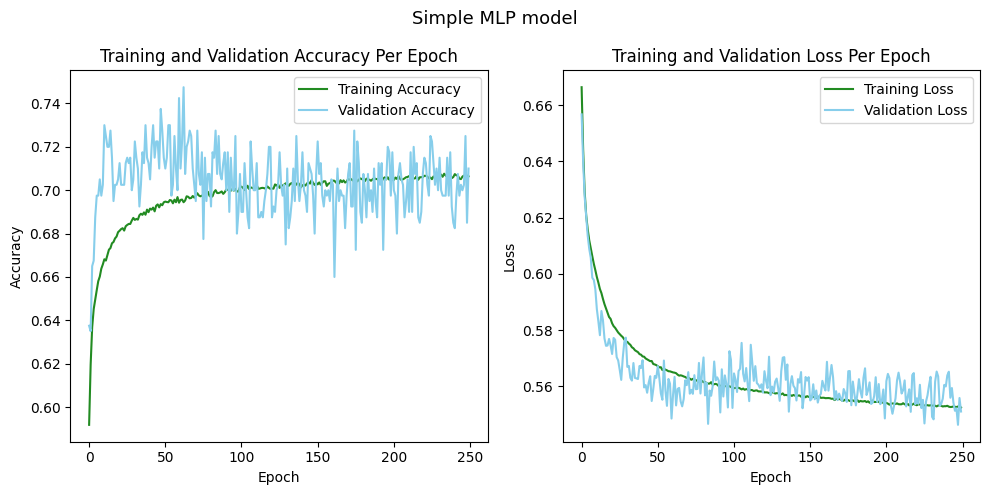

In [ ]:
# Part V: Plot the Training and Validation Accuracy and Loss per Epoch for simple MLP model

# Define the colours wanted for the graphs
colors = ['forestgreen','skyblue']

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))

# Plotting the training and validation accuracy
axes[0].plot(history_1.history['accuracy'], label = 'Training Accuracy', color = colors[0])
axes[0].plot(history_1.history['val_accuracy'], label = 'Validation Accuracy', color = colors[1])
axes[0].set_title('Training and Validation Accuracy Per Epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Plotting the training and validation loss
axes[1].plot(history_1.history['loss'], label = 'Training Loss', color = colors[0])
axes[1].plot(history_1.history['val_loss'], label = 'Validation Loss', color = colors[1])
axes[1].set_title('Training and Validation Loss Per Epoch')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Add a main title for the figure
fig.suptitle('Simple MLP model', fontsize = 13)

# Display the plots
plt.tight_layout()
plt.show()

In [ ]:
# Part VI: Confusion Matrix Interpretation

# Make predictions on the test set (unseen data that was not used in training or valdiation)
y_pred_mlp_test = model_1.predict(x_test_mlp)
y_pred_mlp_test_classes = np.round(y_pred_mlp_test).astype(int) # Convert probabilities to binary prediction

# Compute the confusion matrix using true labels and predicted labels
conf_matrix = confusion_matrix(y_test_mlp, y_pred_mlp_test_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

15/15 [==============================] - 0s 3ms/step
Confusion Matrix:
[[155  81]
 [ 69 167]]


In [ ]:
# Part VII: Observe performance metrics

# Evaluation the simple MLP model on the test set using the compiled metrics
test_loss_1, test_accuracy_1, test_precision_1, test_recall_1 = model_1.evaluate(x_test_mlp, y_test_mlp)
print(f"For simple MLP model with 2 hidden layers (5, 5 neurons per layer):")
print(f"\n   Accuracy on the test set is {test_accuracy_1:.2%}, Precision is {100*test_precision_1:.2f}%, and Recall is {100*test_recall_1:.2f}%")

# Calculate F1 score using precision and recall
test_f1_score_1 = 2 * (test_precision_1 * test_recall_1) / (test_precision_1 + test_recall_1)
print(f"\n   F1 Score on the test set: {test_f1_score_1:.2%}")

15/15 [==============================] - 0s 4ms/step - loss: 0.5798 - accuracy: 0.6822 - precision_8: 0.6734 - recall_8: 0.7076
For simple MLP model with 2 hidden layers (5, 5 neurons per layer):

   Accuracy on the test set is 68.22%, Precision is 67.34%, and Recall is 70.76%

   F1 Score on the test set: 69.01%


Consistent with the confusion matrix and the accuracy and validation plots, these evaluation metrics suggest that the simple MLP model performs moderately well on the test set with room for improvement.

### 2. Optimise simple MLP model

*Attempt 1: Early Stopping*

In [ ]:
# Part I: Attempt to optimise with early stopping

# Implement Early Stopping crieteria and Model Checkpoint to prevent overfitting
# This ensures the best state of the model for the validation set is preserved
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 80)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only = True, monitor ='val_loss')

# Train the model again and save the history
history_1_callbacks = model_1.fit(x_train_mlp,
                        y_train_mlp,
                        epochs = 250,
                        batch_size = 32,
                        validation_data = (x_dev_mlp, y_dev_mlp),
                        callbacks = [early_stopping, model_checkpoint])

# Callbacks allow for efficient training by stopping when the model stops improving

Epoch 1/250
2105/2105 [==============================] - 8s 4ms/step - loss: 0.5525 - accuracy: 0.7067 - precision_8: 0.7341 - recall_8: 0.7436 - val_loss: 0.5561 - val_accuracy: 0.7125 - val_precision_8: 0.7337 - val_recall_8: 0.7019
Epoch 2/250
   1/2105 [..............................] - ETA: 29s - loss: 0.4628 - accuracy: 0.7812 - precision_8: 0.9412 - recall_8: 0.7273

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2105/2105 [==============================] - 8s 4ms/step - loss: 0.5525 - accuracy: 0.7067 - precision_8: 0.7348 - recall_8: 0.7421 - val_loss: 0.5530 - val_accuracy: 0.7100 - val_precision_8: 0.7212 - val_recall_8: 0.7212
Epoch 3/250
2105/2105 [==============================] - 4s 2ms/step - loss: 0.5525 - accuracy: 0.7067 - precision_8: 0.7345 - recall_8: 0.7427 - val_loss: 0.5567 - val_accuracy: 0.6850 - val_precision_8: 0.6934 - val_recall_8: 0.7067
Epoch 4/250
2105/2105 [==============================] - 5s 2ms/step - loss: 0.5525 - accuracy: 0.7063 - precision_8: 0.7347 - recall_8: 0.7411 - val_loss: 0.5582 - val_accuracy: 0.6825 - val_precision_8: 0.6884 - val_recall_8: 0.7115
Epoch 5/250
2105/2105 [==============================] - 4s 2ms/step - loss: 0.5524 - accuracy: 0.7075 - precision_8: 0.7350 - recall_8: 0.7438 - val_loss: 0.5585 - val_accuracy: 0.7200 - val_precision_8: 0.7330 - val_recall_8: 0.7260
Epoch 6/250
2105/2105 [==============================] - 5s 2ms/step - l

By adapting the 'patience' parameter, one may explore how quickly a model reaches a point where additional training results in no changes to the validation set.

*   patience = 10: the training stopped after 22 epochs; hence, the model's performance did not improve after the 12th epoch.
*   patience = 20: the training stopped after 32 epochs; hence, the model's performance did not improve after the 12th epoch.
*   patience = 40: the training stopped after 52; the model's performance did not improve after the 12th epoch, similar to the other scenarios.
*   patience = 60: the training stopped after 72 epochs; the model's performance did not improve after the 12th epoch, similar to the other scenarios.
*   patience = 80: the training steopped after 169 epochs; hence, the model's performance did not improve after the 89th epoch.

While first attempts indicated that the 12th epoch could be the point of convergence for the model, with patience set to 80, the model trained until the 169th epoch. The lower patience values reached a point of overfitting quickly, whereas higher patience values (such as 80) highlighted potential underfitting before overfitting.

Hence, more analysis is needed to assess the model's performance and to decide on when to stop training. Generally, one may stop when the validation loss no longer decreases and starts to increase, or when validation accuracy plateaus.


*Attempt 2: L2 Regularisation*

In [ ]:
# Part II: Attempt to optimise with 'ridge' regularisation (L2)
# this may be particularly useful regarding overfitting concearns

# Set random seeds for reproducibility
RAND_SEED = 27
random.seed(RAND_SEED)
np.random.seed(RAND_SEED)
tf.random.set_seed(RAND_SEED)

# Define the Ridge regularizer with lambda strenght = 0.01
l2_regularizer = regularizers.l2(0.01) # Determines the weights penalization

# Define a new model with L2 regularisation in each dense layer
regularized_model_1 = Sequential ([
    Dense(5, activation = 'relu', input_shape=(100,), kernel_regularizer = l2_regularizer),
    Dense(5, activation = 'relu', kernel_regularizer = l2_regularizer),
    Dense(1, activation = 'sigmoid', kernel_regularizer = l2_regularizer)
])

# Compile the regularised model with an optimizer and metrics
optimizer = SGD(learning_rate = 0.01, momentum = 0.9)  # Use momentum for better convergence
regularized_model_1.compile(optimizer = optimizer,
                            loss = 'binary_crossentropy',
                            metrics = ['accuracy', Precision(), Recall()])

# Continue training the regularised model
history_re = regularized_model_1.fit(x_train_mlp,
                                     y_train_mlp,
                                     epochs = 250,
                                     batch_size = 32,
                                     validation_data = (x_dev_mlp, y_dev_mlp))


Epoch 1/250
2105/2105 [==============================] - 10s 4ms/step - loss: 0.6736 - accuracy: 0.6331 - precision_3: 0.6611 - recall_3: 0.7021 - val_loss: 0.6434 - val_accuracy: 0.6625 - val_precision_3: 0.6780 - val_recall_3: 0.6683
Epoch 2/250
2105/2105 [==============================] - 5s 2ms/step - loss: 0.6507 - accuracy: 0.6437 - precision_3: 0.6692 - recall_3: 0.7146 - val_loss: 0.6322 - val_accuracy: 0.6950 - val_precision_3: 0.6886 - val_recall_3: 0.7548
Epoch 3/250
2105/2105 [==============================] - 5s 2ms/step - loss: 0.6507 - accuracy: 0.6438 - precision_3: 0.6682 - recall_3: 0.7177 - val_loss: 0.6360 - val_accuracy: 0.6775 - val_precision_3: 0.6599 - val_recall_3: 0.7837
Epoch 4/250
2105/2105 [==============================] - 4s 2ms/step - loss: 0.6511 - accuracy: 0.6424 - precision_3: 0.6648 - recall_3: 0.7240 - val_loss: 0.6474 - val_accuracy: 0.6600 - val_precision_3: 0.6667 - val_recall_3: 0.6923
Epoch 5/250
2105/2105 [==============================] - 4s

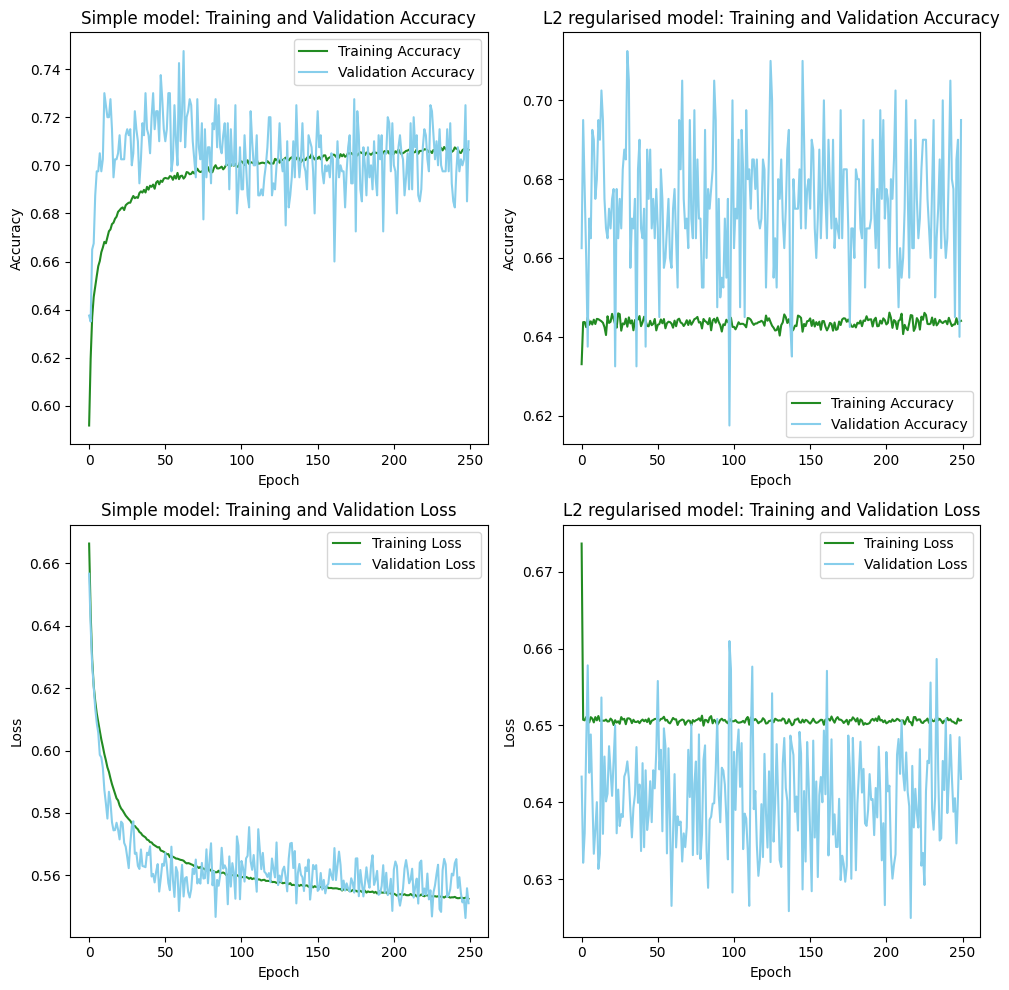

In [ ]:
# Part III: Plot the Training and Validation Accuracy and Loss per Epoch for L2 Regularised model

# Define the colours wanted for the graphs
colors = ['forestgreen','skyblue']

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Plotting the training and validation accuracy for initial model
axes[0, 0].plot(history_1.history['accuracy'], label='Training Accuracy', color = colors[0])
axes[0, 0].plot(history_1.history['val_accuracy'], label='Validation Accuracy', color = colors[1])
axes[0, 0].set_title('Simple model: Training and Validation Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()

# Plotting the training and validation accuracy
axes[0, 1].plot(history_re.history['accuracy'], label = 'Training Accuracy', color = colors[0])
axes[0, 1].plot(history_re.history['val_accuracy'], label = 'Validation Accuracy', color = colors[1])
axes[0, 1].set_title('L2 regularised model: Training and Validation Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

# Plotting the training and validation loss for initial model
axes[1, 0].plot(history_1.history['loss'], label='Training Loss', color = colors[0])
axes[1, 0].plot(history_1.history['val_loss'], label='Validation Loss', color = colors[1])
axes[1, 0].set_title('Simple model: Training and Validation Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()

# Plotting the training and validation loss
axes[1, 1].plot(history_re.history['loss'], label = 'Training Loss', color = colors[0])
axes[1, 1].plot(history_re.history['val_loss'], label = 'Validation Loss', color = colors[1])
axes[1, 1].set_title('L2 regularised model: Training and Validation Loss')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()

# Display the plots
plt.tight_layout()
plt.show()

In [ ]:
# Part IV: Confusion Matrix Interpretation

# Make predictions on the test set (unseen data that was not used in training or valdiation)
y_pred_mlp_test = regularized_model_1.predict(x_test_mlp)
y_pred_mlp_test_classes = np.round(y_pred_mlp_test).astype(int) # Convert probabilities to binary prediction

# Compute the confusion matrix using true labels and predicted labels
conf_matrix = confusion_matrix(y_test_mlp, y_pred_mlp_test_classes)

# Print the confusion matrix
print("Confusion Matrix L2 regularized model:")
print(conf_matrix)

15/15 [==============================] - 0s 2ms/step
Confusion Matrix L2 regularized model:
[[153  83]
 [ 81 155]]


In [ ]:
# Part V: Observe performance metrics

# Evaluate the model with L2 regularisation on the test set
test_loss_l2, test_accuracy_l2, test_precision_l2, test_recall_l2 = regularized_model_1.evaluate(x_test_mlp, y_test_mlp)
print("\nFor simple L2 regularised MLP model with 2 hidden layers (5, 5 neurons per layer):")
print(f"\n   The accuracy on the test set is {test_accuracy_l2:.2%}, precision is {100*test_precision_l2:.2f}%, and recall is {100*test_recall_l2:.2f}%")

# Calculate F1 score using precision and recall
test_f1_score_l2 = 2 * (test_precision_l2 * test_recall_l2) / (test_precision_l2 + test_recall_l2)
print(f"\n   F1 Score on the test set: {test_f1_score_l2:.2%}")


15/15 [==============================] - 0s 6ms/step - loss: 0.6604 - accuracy: 0.6525 - precision_3: 0.6513 - recall_3: 0.6568

For simple L2 regularised MLP model with 2 hidden layers (5, 5 neurons per layer):

   The accuracy on the test set is 65.25%, precision is 65.13%, and recall is 65.68%

   F1 Score on the test set: 65.40%


*Attempt 3: Hyperparameter Tuning (increasing learning rate)*

In [ ]:
# Part VI: Attempt to do Hyperparameter Tuning
# Choose a different learning rate to observe impact on the learning process

# Define new learning rate
new_learning_rate = 0.05 # A higher learning rate poses higher risks of overshooting

# Create a new optimizer with the new learning rate
new_optimizer = SGD(learning_rate = new_learning_rate)

# Clone the architecture of model_1 to create a new model instance and not change the original
model_2 = tf.keras.models.clone_model(model_1)

# Compile the new model with the new optimizer
model_2.compile(optimizer = new_optimizer,
                loss = 'binary_crossentropy',
                metrics = ['accuracy', Precision(), Recall()])

# Retrain the model with the new learning rate
history_tuning = model_2.fit(x_train_mlp,
                          y_train_mlp,
                          epochs = 250,
                          batch_size = 32,
                          validation_data = (x_dev_mlp, y_dev_mlp))


Epoch 1/250
2105/2105 [==============================] - 11s 5ms/step - loss: 0.6267 - accuracy: 0.6315 - precision_9: 0.6737 - recall_9: 0.6581 - val_loss: 0.5862 - val_accuracy: 0.6925 - val_precision_9: 0.7157 - val_recall_9: 0.6779
Epoch 2/250
2105/2105 [==============================] - 7s 3ms/step - loss: 0.6019 - accuracy: 0.6591 - precision_9: 0.6987 - recall_9: 0.6837 - val_loss: 0.5767 - val_accuracy: 0.7075 - val_precision_9: 0.7040 - val_recall_9: 0.7548
Epoch 3/250
2105/2105 [==============================] - 6s 3ms/step - loss: 0.5933 - accuracy: 0.6658 - precision_9: 0.7084 - recall_9: 0.6811 - val_loss: 0.5715 - val_accuracy: 0.6875 - val_precision_9: 0.6948 - val_recall_9: 0.7115
Epoch 4/250
2105/2105 [==============================] - 4s 2ms/step - loss: 0.5883 - accuracy: 0.6707 - precision_9: 0.7094 - recall_9: 0.6940 - val_loss: 0.5661 - val_accuracy: 0.7025 - val_precision_9: 0.7089 - val_recall_9: 0.7260
Epoch 5/250
2105/2105 [==============================] - 5s

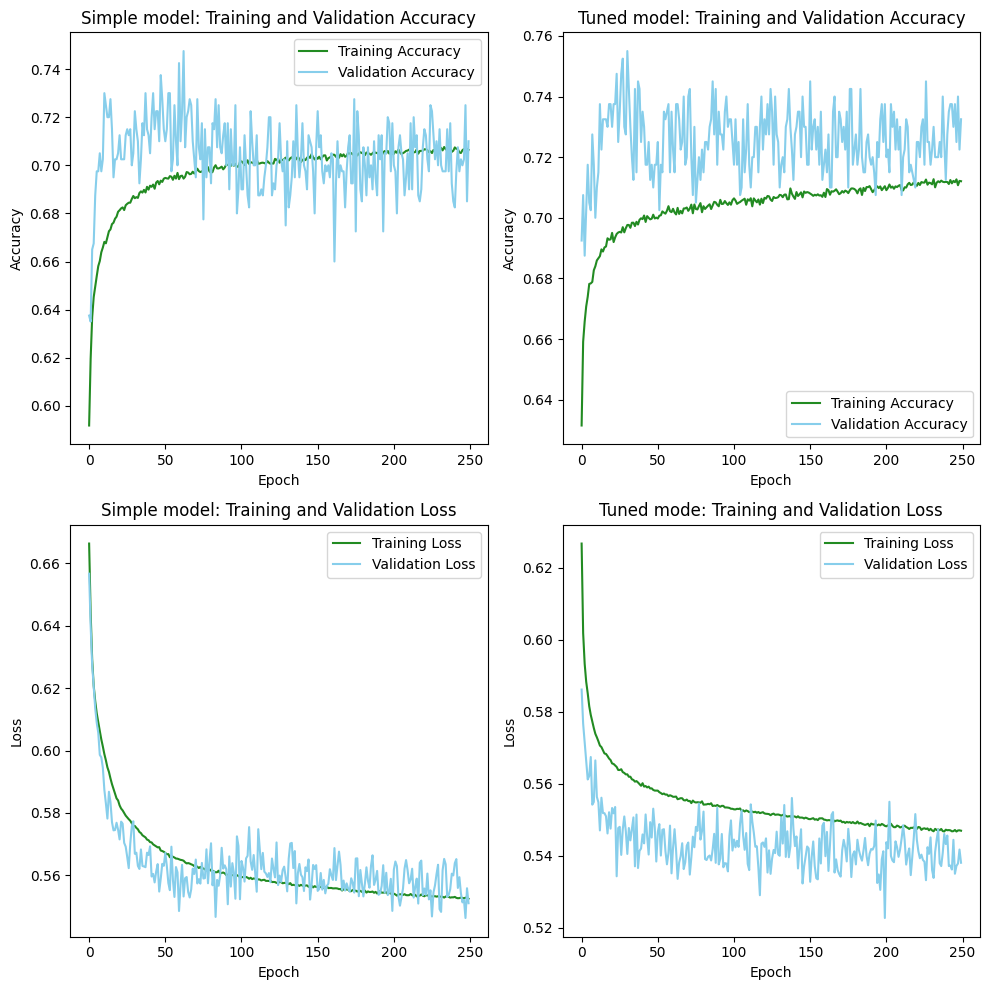

In [ ]:
# Part VII: Plot the Training and Validation Accuracy and Loss per Epoch for Tuned model

# Define the colours wanted for the graphs
colors = ['forestgreen','skyblue']

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Plotting the training and validation accuracy for initial model
axes[0, 0].plot(history_1.history['accuracy'], label='Training Accuracy', color = colors[0])
axes[0, 0].plot(history_1.history['val_accuracy'], label='Validation Accuracy', color = colors[1])
axes[0, 0].set_title('Simple model: Training and Validation Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()

# Plotting the training and validation accuracy for tuned model
axes[0, 1].plot(history_tuning.history['accuracy'], label = 'Training Accuracy', color = colors[0])
axes[0, 1].plot(history_tuning.history['val_accuracy'], label = 'Validation Accuracy', color = colors[1])
axes[0, 1].set_title('Tuned model: Training and Validation Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

# Plotting the training and validation loss for initial model
axes[1, 0].plot(history_1.history['loss'], label='Training Loss', color = colors[0])
axes[1, 0].plot(history_1.history['val_loss'], label='Validation Loss', color = colors[1])
axes[1, 0].set_title('Simple model: Training and Validation Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()

# Plotting the training and validation loss for tuned model
axes[1, 1].plot(history_tuning.history['loss'], label = 'Training Loss', color = colors[0])
axes[1, 1].plot(history_tuning.history['val_loss'], label = 'Validation Loss', color = colors[1])
axes[1, 1].set_title('Tuned mode: Training and Validation Loss')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()

# Display the plots
plt.tight_layout()
plt.show()

In [ ]:
# Part VIII: Confusion Matrix Interpretation

# Make predictions on the test set (unseen data that was not used in training or valdiation)
y_pred_mlp_test = model_2.predict(x_test_mlp)
y_pred_mlp_test_classes = np.round(y_pred_mlp_test).astype(int) # Convert probabilities to binary prediction

# Compute the confusion matrix using true labels and predicted labels
conf_matrix = confusion_matrix(y_test_mlp, y_pred_mlp_test_classes)

# Print the confusion matrix
print("Confusion Matrix Tuned model:")
print(conf_matrix)

15/15 [==============================] - 0s 4ms/step
Confusion Matrix Tuned model:
[[160  76]
 [ 72 164]]


By changing the learning rate, the model has seen an increase in True Negative instances (from 155 to 160), which in turn has decreased Type I errors. However, the confusion matrix also shows a decrease in True Positive instances (from 167 to 164), which in turn increased Type II errors.

In [ ]:
# Part IX: Observe performance metrics

# Evaluate the tuned model with new learning rate on the test set
test_loss_2, test_accuracy_2, test_precision_2, test_recall_2 = model_2.evaluate(x_test_mlp, y_test_mlp)
print("\nFor tuned MLP model with 2 hidden layers (5, 5 neurons per layer):")
print(f"\n   The accuracy on the test set is {test_accuracy_2:.2%}, precision is {100*test_precision_2:.2f}%, and recall is {100*test_recall_2:.2f}%")

# Calculate F1 score using precision and recall
test_f1_score_2 = 2 * (test_precision_2 * test_recall_2) / (test_precision_2 + test_recall_2)
print(f"\n   F1 Score on the test set: {test_f1_score_2:.2%}")

15/15 [==============================] - 0s 2ms/step - loss: 0.5860 - accuracy: 0.6864 - precision_9: 0.6833 - recall_9: 0.6949

For tuned MLP model with 2 hidden layers (5, 5 neurons per layer):

   The accuracy on the test set is 68.64%, precision is 68.33%, and recall is 69.49%

   F1 Score on the test set: 68.91%


By comparing the performance metrics with those recorded by the simple MLP model, one may see that the tuned model with an ajusted learning rate performs better in terms of test accuracy, test recall, and f1 score.

### 3. Comparison with more complex MLPs

To better observe the performance of the simple MLP, one may also define new models trained on the same dataset. Among others, such models could have changes in the number of neurons and layers.

*Attempt 1: Learning Rate Decay model*

In [ ]:
# Part I: Initialise first new MLP model with Learning Rate Decay

# Set random seeds for reproducibility
RAND_SEED = 27
random.seed(RAND_SEED)
np.random.seed(RAND_SEED)
tf.random.set_seed(RAND_SEED)

# Define the MLP model
model_LRD = Sequential([
    Dense(5, activation='relu', input_shape=(100,)), # First hidden layer: 5 neurons
    Dense(5, activation='relu'),  # Second hidden layer: 5 neurons
    Dense(1, activation='sigmoid') # Output layer: 1 neuron, binary classification
])

# Summary of the model to confirm the architecture
model_LRD.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 5)                 505       
                                                                 
 dense_13 (Dense)            (None, 5)                 30        
                                                                 
 dense_14 (Dense)            (None, 1)                 6         
                                                                 
Total params: 541 (2.11 KB)
Trainable params: 541 (2.11 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Part II: Train the Learning Rate Decay model
# This model may be seen as an advanced version of model_2

# Initial learning rate
initial_learning_rate = 0.01

# Define a lrd function that will be used as callback during training
def lr_decay(epoch, lr):
    # Check whether the current epoch is at least 150 and multiple of 50
    if epoch >= 150 and epoch % 50 == 0:
        # Reduce the learning rate to 10% of its current value
        return lr * 0.1
    # If conditions not met, return current learning rate
    return lr

# Compile the model with a custom learning rate
optimizer = SGD(learning_rate = initial_learning_rate)
model_LRD.compile(optimizer = optimizer,
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy', Precision(), Recall()])

# Learning rate scheduler callback using the lr_decay function
lr_scheduler = LearningRateScheduler(lr_decay)

# Train the model and save the history
history_LRD = model_LRD.fit(x_train_mlp,
                            y_train_mlp,
                            epochs = 250,
                            batch_size = 32,
                            validation_data =(x_dev_mlp, y_dev_mlp),
                            callbacks =[lr_scheduler])

Epoch 1/250
2105/2105 [==============================] - 8s 3ms/step - loss: 0.6664 - accuracy: 0.5918 - precision_5: 0.6131 - recall_5: 0.7268 - val_loss: 0.6567 - val_accuracy: 0.6375 - val_precision_5: 0.6567 - val_recall_5: 0.6346 - lr: 0.0100
Epoch 2/250
2105/2105 [==============================] - 5s 3ms/step - loss: 0.6441 - accuracy: 0.6196 - precision_5: 0.6546 - recall_5: 0.6733 - val_loss: 0.6400 - val_accuracy: 0.6350 - val_precision_5: 0.6490 - val_recall_5: 0.6490 - lr: 0.0100
Epoch 3/250
2105/2105 [==============================] - 9s 4ms/step - loss: 0.6292 - accuracy: 0.6368 - precision_5: 0.6717 - recall_5: 0.6825 - val_loss: 0.6274 - val_accuracy: 0.6650 - val_precision_5: 0.6907 - val_recall_5: 0.6442 - lr: 0.0100
Epoch 4/250
2105/2105 [==============================] - 4s 2ms/step - loss: 0.6208 - accuracy: 0.6452 - precision_5: 0.6812 - recall_5: 0.6840 - val_loss: 0.6206 - val_accuracy: 0.6675 - val_precision_5: 0.6984 - val_recall_5: 0.6346 - lr: 0.0100
Epoch 5/

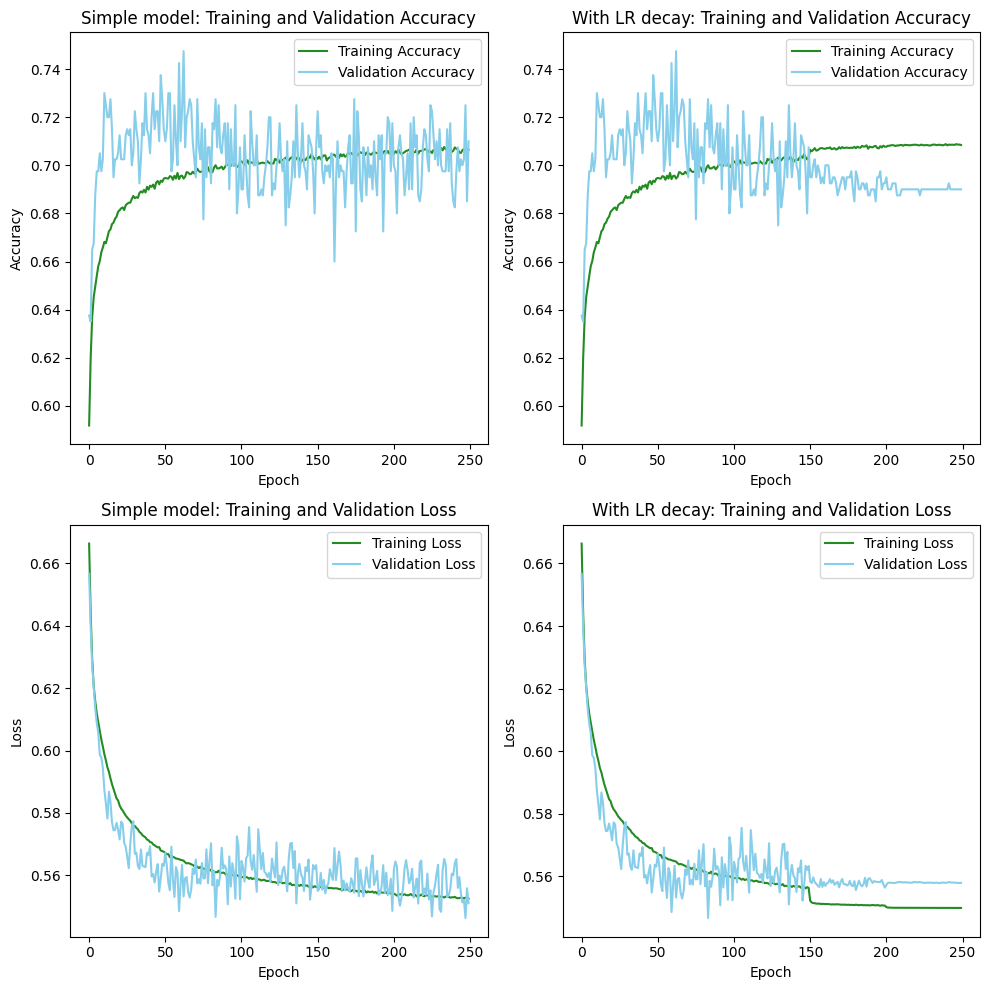

In [ ]:
# Part III: Plot the differences between the simple MLP model and LRD model

# Define the colours wanted for the graphs
colors = ['forestgreen','skyblue']

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Plotting the training and validation accuracy for initial model
axes[0, 0].plot(history_1.history['accuracy'], label='Training Accuracy', color = colors[0])
axes[0, 0].plot(history_1.history['val_accuracy'], label='Validation Accuracy', color = colors[1])
axes[0, 0].set_title('Simple model: Training and Validation Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()

# Plotting the training and validation accuracy for model with learning rate decay
axes[0, 1].plot(history_LRD.history['accuracy'], label='Training Accuracy', color = colors[0])
axes[0, 1].plot(history_LRD.history['val_accuracy'], label='Validation Accuracy', color = colors[1])
axes[0, 1].set_title('With LR decay: Training and Validation Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

# Plotting the training and validation loss for initial model
axes[1, 0].plot(history_1.history['loss'], label='Training Loss', color = colors[0])
axes[1, 0].plot(history_1.history['val_loss'], label='Validation Loss', color = colors[1])
axes[1, 0].set_title('Simple model: Training and Validation Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()

# Plotting the training and validation loss for model with learning rate decay
axes[1, 1].plot(history_LRD.history['loss'], label='Training Loss', color = colors[0])
axes[1, 1].plot(history_LRD.history['val_loss'], label='Validation Loss', color = colors[1])
axes[1, 1].set_title('With LR decay: Training and Validation Loss')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()

# Display the plots
plt.tight_layout()
plt.show()

In [ ]:
# Part IV: LRD Confusion Matrix Interpretation

# Make predictions on the test set (unseen data that was not used in training or valdiation)
y_pred_mlp_test = model_LRD.predict(x_test_mlp)
y_pred_mlp_test_classes = np.round(y_pred_mlp_test).astype(int) # Convert probabilities to binary prediction

# Compute the confusion matrix using true labels and predicted labels
conf_matrix = confusion_matrix(y_test_mlp, y_pred_mlp_test_classes)

# Print the confusion matrix
print("Confusion Matrix LRD model:")
print(conf_matrix)

15/15 [==============================] - 0s 3ms/step
Confusion Matrix LRD model:
[[160  76]
 [ 70 166]]


According to this confusion matrix, the LRD model has achieved a higher number of True Negative (TN) instances than the initil simple MLP model (which has 155). However, this model has also achieved a lower number of True Positive (TP) instances, compared to 167.

*Attempt 2: Complex model with 3 hidden layers*

In [ ]:
# Part V: Initialise an even more complex MLP with more layers

# Building a different MultiLayer Perceptron
input_features = 100 # This must be 100
neurons_first_hidden_layer = 10
neurons_second_hidden_layer = 5
neurons_third_hidden_layer = 5 # Additional hidden layer
neurons_output_layer = 1 # This must be 1

In [ ]:
# Part VI: Define the new complex MLP model

# Set random seeds for reproducibility
RAND_SEED = 27
random.seed(RAND_SEED)
np.random.seed(RAND_SEED)
tf.random.set_seed(RAND_SEED)

# Define the MLP model with 4 layers
model_complex = Sequential([
    Dense(neurons_first_hidden_layer, activation='relu', input_shape=(input_features,)),
    Dense(neurons_second_hidden_layer, activation='relu'),
    Dense(neurons_third_hidden_layer, activation='relu'), # New hidden layer
    Dense(neurons_output_layer, activation='sigmoid')  # Binary classification
])

# Summary of the model to confirm the architecture
model_complex.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 10)                1010      
                                                                 
 dense_16 (Dense)            (None, 5)                 55        
                                                                 
 dense_17 (Dense)            (None, 5)                 30        
                                                                 
 dense_18 (Dense)            (None, 1)                 6         
                                                                 
Total params: 1101 (4.30 KB)
Trainable params: 1101 (4.30 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Part VII: Train the complex MLP model

# Compile the model with a custom learning rate
optimizer = SGD(learning_rate = 0.01)
model_complex.compile(optimizer = optimizer,
                      loss = 'binary_crossentropy',
                      metrics = ['accuracy', Precision(), Recall()])

# Train the model and save the history
history_complex = model_complex.fit(x_train_mlp,
                                    y_train_mlp,
                                    epochs = 250,
                                    batch_size = 32,
                                    validation_data = (x_dev_mlp, y_dev_mlp))


Epoch 1/250
2105/2105 [==============================] - 7s 3ms/step - loss: 0.6507 - accuracy: 0.6220 - precision_7: 0.6203 - recall_7: 0.8313 - val_loss: 0.6383 - val_accuracy: 0.6350 - val_precision_7: 0.6062 - val_recall_7: 0.8510
Epoch 2/250
2105/2105 [==============================] - 5s 2ms/step - loss: 0.6366 - accuracy: 0.6415 - precision_7: 0.6445 - recall_7: 0.7969 - val_loss: 0.6213 - val_accuracy: 0.6450 - val_precision_7: 0.6204 - val_recall_7: 0.8173
Epoch 3/250
2105/2105 [==============================] - 5s 2ms/step - loss: 0.6271 - accuracy: 0.6510 - precision_7: 0.6576 - recall_7: 0.7811 - val_loss: 0.6094 - val_accuracy: 0.6825 - val_precision_7: 0.6540 - val_recall_7: 0.8269
Epoch 4/250
2105/2105 [==============================] - 6s 3ms/step - loss: 0.6182 - accuracy: 0.6586 - precision_7: 0.6687 - recall_7: 0.7688 - val_loss: 0.6051 - val_accuracy: 0.6775 - val_precision_7: 0.6513 - val_recall_7: 0.8173
Epoch 5/250
2105/2105 [==============================] - 5s 

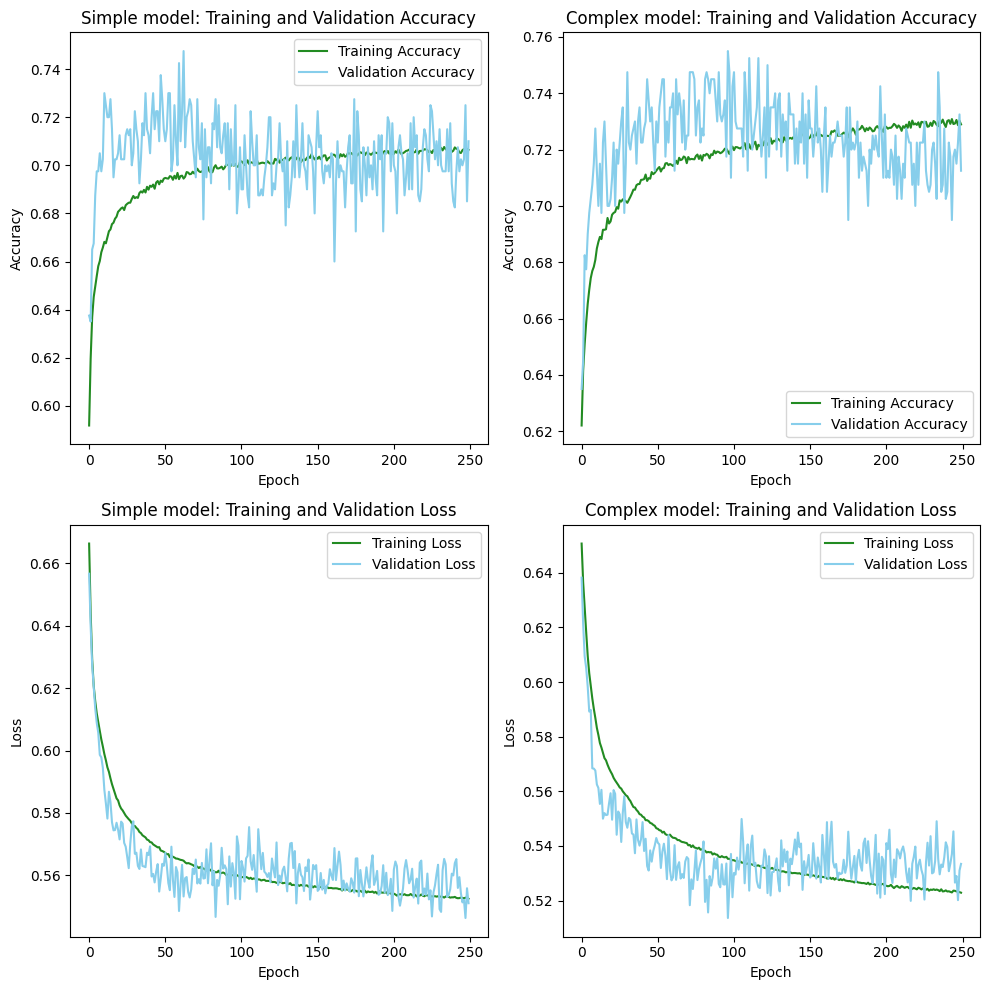

In [ ]:
# Part VII: Plot the differences between the simple and complex MLP model

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Plotting the training and validation accuracy for initial SGD
axes[0, 0].plot(history_1.history['accuracy'], label='Training Accuracy', color = colors[0])
axes[0, 0].plot(history_1.history['val_accuracy'], label='Validation Accuracy', color = colors[1])
axes[0, 0].set_title('Simple model: Training and Validation Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()

# Plotting the training and validation accuracy for SGD with decay
axes[0, 1].plot(history_complex.history['accuracy'], label='Training Accuracy', color = colors[0])
axes[0, 1].plot(history_complex.history['val_accuracy'], label='Validation Accuracy', color = colors[1])
axes[0, 1].set_title('Complex model: Training and Validation Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

# Plotting the training and validation loss for initial SGD
axes[1, 0].plot(history_1.history['loss'], label='Training Loss', color = colors[0])
axes[1, 0].plot(history_1.history['val_loss'], label='Validation Loss', color = colors[1])
axes[1, 0].set_title('Simple model: Training and Validation Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()

# Plotting the training and validation loss for SGD with decay
axes[1, 1].plot(history_complex.history['loss'], label='Training Loss', color = colors[0])
axes[1, 1].plot(history_complex.history['val_loss'], label='Validation Loss', color = colors[1])
axes[1, 1].set_title('Complex model: Training and Validation Loss')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()

# Display the plots
plt.tight_layout()
plt.show()

According to this plot, both the training accuracy and loss resulting from the complex model follow a similar curve with to simple one. However, validation accuracy starts to slowly decrease after 125 epochs and does not return to an upward trajectory compared to the simple model. Similarly, the validation loss sits higher than the training loss after epoch 100.

In [ ]:
# Part VIII: Confusion Matrix Interpretation

# Make predictions on the test set (unseen data that was not used in training or valdiation)
y_pred_mlp_test = model_complex.predict(x_test_mlp)
y_pred_mlp_test_classes = np.round(y_pred_mlp_test).astype(int) # Convert probabilities to binary prediction

# Compute the confusion matrix using true labels and predicted labels
conf_matrix = confusion_matrix(y_test_mlp, y_pred_mlp_test_classes)

# Print the confusion matrix
print("Confusion Matrix complex model:")
print(conf_matrix)

15/15 [==============================] - 0s 2ms/step
Confusion Matrix complex model:
[[163  73]
 [ 74 162]]


### Testing the models

In [ ]:
# In order to decide on the best performing model, one must compare and contrast all performance metrics

# Print Evaluation Metrics for simple MLP model
test_loss_1, test_accuracy_1, test_precision_1, test_recall_1 = model_1.evaluate(x_test_mlp, y_test_mlp)
print(f"For simple MLP model with 2 hidden layers (5, 5 neurons per layer):")
print(f"\nTest Accuracy is {100*test_accuracy_1:.4}%, Precision is {100*test_precision_1:.4f}%, and Recall is {100*test_recall_1:.4f}%\n")
print('-'*50)

# Print Evaluation Metrics for L2 Regularised simple MLP model
test_loss_l2, test_accuracy_l2, test_precision_l2, test_recall_l2 = regularized_model_1.evaluate(x_test_mlp, y_test_mlp)
print("\nFor simple L2 regularised MLP model with 2 hidden layers (5, 5 neurons per layer):")
print(f"\nTest Accuracy is {100*test_accuracy_l2:.4}%, Precision is {100*test_precision_l2:.4f}%, and Recall is {100*test_recall_l2:.4f}%\n")
print('-'*50)

# Evaluate the tuned model with new learning rate on the test set
test_loss_2, test_accuracy_2, test_precision_2, test_recall_2 = model_2.evaluate(x_test_mlp, y_test_mlp)
print("\nFor tuned MLP model with 2 hidden layers (5, 5 neurons per layer):")
print(f"\nTest accuracy is {test_accuracy_2:.2%}, Precision is {100*test_precision_2:.2f}%, and Recall is {100*test_recall_2:.2f}%\n")

# Print Evaluation Metrics for MLP model with Learning Rate Scheduler
test_loss_LRD, test_accuracy_LRD, test_precision_LRD, test_recall_LRD = model_LRD.evaluate(x_test_mlp, y_test_mlp)
print(f"For Learning Rate Decay model with 2 hidden layers, (5, 5 neurons per layer):")
print(f"\nTest Accuracy is {100*test_accuracy_LRD:.4}%, Precision is {100*test_precision_LRD:.4f}%, and Recall is {100*test_recall_LRD:.4f}%\n")
print('-'*50)

# Print Evaluation Metrics for complex MLP model
test_loss_complex, test_accuracy_complex, test_precision_complex, test_recall_complex = model_complex.evaluate(x_test_mlp, y_test_mlp)
print(f"For complex model with 3 hidden layers (10, 5, 5 neurons per layer):")
print(f"\nTest Accuracy is {100*test_accuracy_complex:.4}%, Precision is {100*test_precision_complex:.4f}%, and Recall is {100*test_recall_complex:.4f}%")


15/15 [==============================] - 0s 2ms/step - loss: 0.5852 - accuracy: 0.6822 - precision_8: 0.6693 - recall_8: 0.7203
For simple MLP model with 2 hidden layers (5, 5 neurons per layer):

Test Accuracy is 68.22%, Precision is 66.9291%, and Recall is 72.0339%

--------------------------------------------------
15/15 [==============================] - 0s 2ms/step - loss: 0.6604 - accuracy: 0.6525 - precision_3: 0.6513 - recall_3: 0.6568

For simple L2 regularised MLP model with 2 hidden layers (5, 5 neurons per layer):

Test Accuracy is 65.25%, Precision is 65.1260%, and Recall is 65.6780%

--------------------------------------------------
15/15 [==============================] - 0s 2ms/step - loss: 0.5860 - accuracy: 0.6864 - precision_9: 0.6833 - recall_9: 0.6949

For tuned MLP model with 2 hidden layers (5, 5 neurons per layer):

Test accuracy is 68.64%, Precision is 68.33%, and Recall is 69.49%

15/15 [==============================] - 0s 2ms/step - loss: 0.5804 - accuracy:

In [ ]:
# Finding the model with the highest test accuracy
best_accuracy = max(test_accuracy_1, test_accuracy_l2, test_accuracy_LRD, test_accuracy_complex)

# Print the results
print("Best accuracy on the test set is from the:")
if best_accuracy == test_accuracy_1:
    print(f"  Simple MLP Model: {100*best_accuracy:.4%}%")
elif best_accuracy == test_accuracy_l2:
    print(f"  L2 Regularised Model: {100*best_accuracy:.4}%")
elif best_accuracy == test_accuracy_2:
    print(f"  Tuned Model: {100*best_accuracy:.4}%")
elif best_accuracy == test_accuracy_LRD:
    print(f"  Learning Rate Decay Model: {100*best_accuracy:.4}%")
else:
    print(f"  Complex Model:{100*best_accuracy:.4}%")

Best accuracy on the test set is from the:
  Learning Rate Decay Model: 69.07%


Hence, by choosing accuracy as the determinant factor, the Learning Rate Decay model with two hidden layers is the best performing model for the test data, closely followed by the complex model. This model improves test accuracy by almost 0.90% and precision by almost 1.5%, while decreasing the recall by nearly 2%.